In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import scipy as scipy
import scipy.stats as sc
import numpy as np
import pandas as pd
import os
import re
from calendar import isleap

In [23]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

In [2]:
one_file = scipy.io.loadmat('../aaron_aht_stuff/transients_by_month/2017_3_iTE.mat')

times = pd.date_range('2001-01-01', '2018-12-31 18:00:00', freq='6H')

dataDir = '../aaron_aht_stuff/transients_by_month/'

all_te = np.zeros((len(times), 361))

years = range(2001, 2019)
months = range(1, 13)

tes_list = []

for year in years:
    #print(year)
    for month in months:
    
    
        file_name = f'{year}_{month}_iTE.mat'
    
        data = scipy.io.loadmat(dataDir+file_name)
        
        len_data = len(data['iTE'][:,0])

        if month == 12:
            
            len_time = len(pd.date_range(f'{year}-{month}-01', f'{year + 1}-1-01 00:00:00', freq='6H'))
        
        else:
            len_time = len(pd.date_range(f'{year}-{month}-01', f'{year}-{(month + 1)}-01 00:00:00', freq='6H'))
        
        if (len_time - len_data) != 1:
            print(f'{year}_{month}')
        #print(f'Data is: {len_data} and time is: {len_time}')

        #all_te[time_idx,:] = data['iTE']
        tes_list.append(data['iTE'])



2004_2
2008_2
2012_2
2016_2


In [3]:
tes_array = np.vstack(np.array([np.array(xi) for xi in tes_list]))

orig_times = pd.date_range('2001-01-01', '2018-12-31 18:00:00', freq='6H')
times = orig_times[(orig_times.day != 29) | (orig_times.month != 2)]

print(len(times))
print(len(orig_times))

lats = one_file['lat'].flatten()


te_ds = xr.Dataset(
                        data_vars = dict(
                            te_aht=(['time', 'latitude'], tes_array),
                        ),
                        coords=dict(
                            time = times,
                            latitude=lats)
    )

26280
26296


<ipython-input-3-c59c8fddae23>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tes_array = np.vstack(np.array([np.array(xi) for xi in tes_list]))


In [4]:
te_ds_conv = te_ds.differentiate('latitude')

te_ds_conv

<xarray.Dataset>
Dimensions:   (time: 26280, latitude: 361)
Coordinates:
  * time      (time) datetime64[ns] 2001-01-01 ... 2018-12-31T18:00:00
  * latitude  (latitude) float64 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
Data variables:
    te_aht    (time, latitude) float64 2.182e+12 3.659e+12 ... 3.02e+11

In [5]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series_full.nc')

In [6]:
aht_ds

<xarray.Dataset>
Dimensions:                     (time: 63184, latitude: 361)
Coordinates:
  * time                        (time) datetime64[ns] 1979-01-01 ... 2022-03-...
  * latitude                    (latitude) float64 90.0 89.5 ... -89.5 -90.0
Data variables: (12/18)
    total_aht                   (time, latitude) float64 ...
    eddy_aht                    (time, latitude) float64 ...
    mmc_aht                     (time, latitude) float64 ...
    total_aht_no_seasons        (time, latitude) float64 ...
    eddy_aht_no_seasons         (time, latitude) float64 ...
    mmc_aht_no_seasons          (time, latitude) float64 ...
    ...                          ...
    total_aht_dry               (time, latitude) float64 ...
    eddy_aht_dry                (time, latitude) float64 ...
    mmc_aht_dry                 (time, latitude) float64 ...
    total_aht_no_seasons_dry    (time, latitude) float64 ...
    eddy_aht_no_seasons_dry     (time, latitude) float64 ...
    mmc_aht_no_seasons_dry      (time, latitude) float64 ...

In [7]:
mse_tendency_ds = xr.open_dataset('../MSE_zonal_tendency.nc')

In [8]:
mse_tendency_ds_subset_te = mse_tendency_ds.sel(time=slice('2001-01-01', '2018-12-31'))

mse_tendency_ds_subset_te = mse_tendency_ds_subset_te.sel(time=~((mse_tendency_ds_subset_te.time.dt.month == 2) & (mse_tendency_ds_subset_te.time.dt.day == 29)))

mse_tendency_ds_subset_te = mse_tendency_ds_subset_te.sel(time=mse_tendency_ds_subset_te.time.dt.month.isin([12, 1, 2]))

#mse_tendency_ds_subset_te.time

te_ds_conv_subset = te_ds_conv.sel(time=mse_tendency_ds_subset_te.time)

In [9]:
mse_tendency_ds_subset = mse_tendency_ds.sel(time=mse_tendency_ds.time.dt.month.isin([12, 1, 2]))

In [10]:
mse_tendency_ds_subset

<xarray.Dataset>
Dimensions:       (time: 15760, latitude: 721)
Coordinates:
  * latitude      (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time          (time) datetime64[ns] 1979-01-01 ... 2022-02-28T18:00:00
Data variables:
    T_tendency    (time, latitude) float64 ...
    q_tendency    (time, latitude) float64 ...
    z_tendency    (time, latitude) float64 ...
    MSE_tendency  (time, latitude) float64 ...

In [11]:
aht_ds_subset = aht_ds.sel(time=mse_tendency_ds_subset.time)

In [12]:
aht_ds_conv = aht_ds_subset.differentiate('latitude')

In [13]:
aht_var = 'total_aht'

corrs_mse = -xr.corr(aht_ds_conv[aht_var], mse_tendency_ds_subset.MSE_tendency, dim='time')
corrs_T = -xr.corr(aht_ds_conv[aht_var], mse_tendency_ds_subset.T_tendency, dim='time')
corrs_q = -xr.corr(aht_ds_conv[aht_var], mse_tendency_ds_subset.q_tendency, dim='time')
corrs_z = -xr.corr(aht_ds_conv[aht_var], mse_tendency_ds_subset.z_tendency, dim='time')

corrs_mmc_mse = -xr.corr(aht_ds_conv['mmc_aht'], mse_tendency_ds_subset.MSE_tendency, dim='time')
corrs_eddy_mse = -xr.corr(aht_ds_conv['eddy_aht'], mse_tendency_ds_subset.MSE_tendency, dim='time')
corrs_total_mse = -xr.corr(aht_ds_conv['total_aht'], mse_tendency_ds_subset.MSE_tendency, dim='time')

In [14]:
corrs_te_mse = -xr.corr(te_ds_conv_subset.te_aht, mse_tendency_ds_subset_te.MSE_tendency, dim='time')



In [15]:
mse_tendency_ds_subset

<xarray.Dataset>
Dimensions:       (time: 15760, latitude: 721)
Coordinates:
  * latitude      (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time          (time) datetime64[ns] 1979-01-01 ... 2022-02-28T18:00:00
Data variables:
    T_tendency    (time, latitude) float64 ...
    q_tendency    (time, latitude) float64 ...
    z_tendency    (time, latitude) float64 ...
    MSE_tendency  (time, latitude) float64 ...

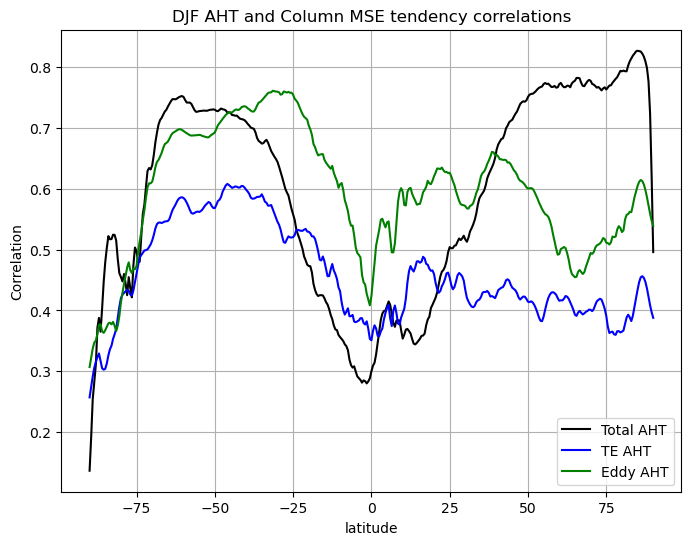

In [18]:
plt.figure(figsize=(8,6))
corrs_total_mse.plot.line(label='Total AHT', color='k')
corrs_te_mse.plot.line(label='TE AHT', color='b')
corrs_eddy_mse.plot.line(label='Eddy AHT', color='g')
#corrs_mmc_mse.plot.line(label='MMC AHT', color='orange')

plt.legend(loc=0)
plt.grid()
plt.ylabel('Correlation')
plt.title('DJF AHT and Column MSE tendency correlations')

#plt.savefig('../figures/AHT_MSE_corr_plots/total_eddy_te_mse_corr')
plt.show()

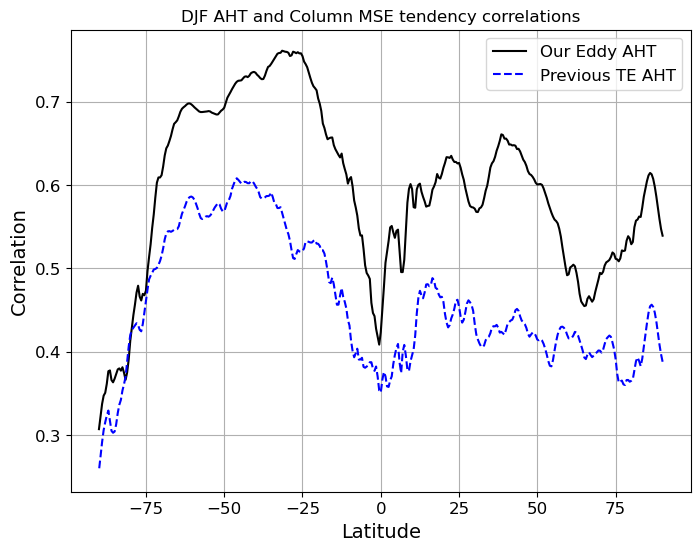

In [19]:
plt.figure(figsize=(8,6))
corrs_eddy_mse.plot.line(label='Our Eddy AHT', color='k')
corrs_te_mse.plot.line(label='Previous TE AHT', linestyle= '--', color='b')
#corrs_mmc_mse.plot.line(label='MMC AHT', color='orange')

plt.legend(loc=0, fontsize=12)
plt.grid()
plt.ylabel('Correlation', fontsize=14)
plt.xlabel('Latitude', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('DJF AHT and Column MSE tendency correlations')

#plt.savefig('../figures/AHT_MSE_corr_plots/eddy_te_mse_corr_dissertation')
plt.show()

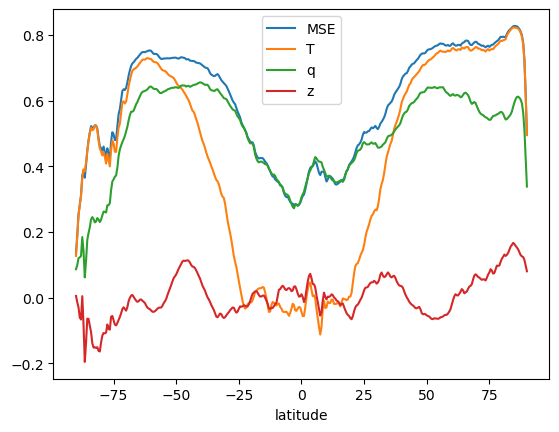

In [20]:
corrs_mse.plot.line(label='MSE')
corrs_T.plot.line(label='T')
corrs_q.plot.line(label='q')
corrs_z.plot.line(label='z')

plt.legend(loc=0)
plt.show()

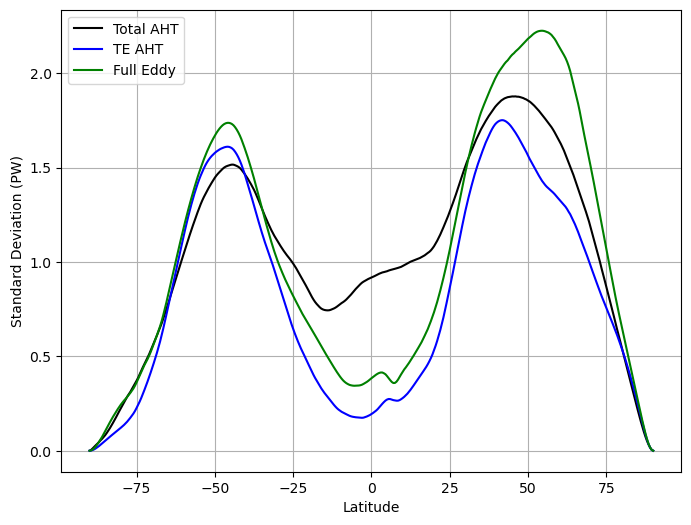

In [21]:
te_ds_subset = te_ds.sel(time=mse_tendency_ds_subset_te.time)

plt.figure(figsize=(8,6))
(aht_ds_subset.total_aht.std('time') / 1e15).plot(color='k', label='Total AHT')
(te_ds_subset.te_aht.std('time') / 1e15).plot(color='b', label='TE AHT')
(aht_ds_subset.eddy_aht.std('time') / 1e15).plot(color='g', label='Full Eddy')
#(aht_ds_subset.mmc_aht.std('time') / 1e15).plot(color='orange', label='MMC AHT')

plt.legend(loc=0)
plt.grid()

plt.xlabel('Latitude')
plt.ylabel('Standard Deviation (PW)')

#plt.savefig('../figures/AHT_MSE_corr_plots/total_eddy_te_mse_std_dev')

plt.show()

In [46]:
mass_flux_ds = xr.open_mfdataset('../era5_data/mass_flux/*').sel(time=slice('1980-01-01', '2014-12-31'))

mass_flux_ds = mass_flux_ds.compute()


geom_mass = 2 * np.pi * np.cos(np.deg2rad(mass_flux_ds.latitude.values)) * a / g

mass_aht = mass_flux_ds.mass_aht * geom_mass

mass_aht = mass_aht[:,::2] #To get the right latitudes

<xarray.DataArray 'month' (time: 12636)>
array([ 1,  1,  1, ..., 12, 12, 12])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2014-12-31T18:00:00

In [25]:
mse_test = mse_tendency_ds.MSE_tendency.sel(time=mass_aht.time)[:,::2]
#mse_temp = mse_temp.sel(time=~((mse_temp.time.dt.month == 2) & (mse_temp.time.dt.day == 29)))
#mse_test = mse_temp.sel(time=mse_temp.time.dt.month.isin([1,2,3]))
#aht_test = aht_ds.sel(time=slice('2008-01-01','2008-01-31'))

aht_test = aht_ds.sel(time=mass_aht.time)
#aht_temp = aht_temp.sel(time=~((aht_temp.time.dt.month == 2) & (aht_temp.time.dt.day == 29)))
#aht_test = aht_temp.sel(time=aht_temp.time.dt.month.isin([1,2,3]))

#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  
#geom_test = 2 * np.pi * np.cos(np.deg2rad(np.linspace(-90, 90, 361))) * a / g


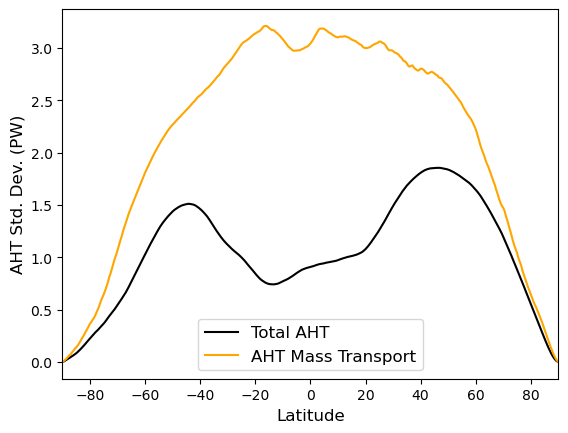

In [26]:
plt.plot(np.linspace(90, -90, 361), np.std(aht_test.total_aht, axis=0) / 1e15,
         color='k', label='Total AHT')

plt.plot(np.linspace(90, -90, 361), np.std(mass_aht, axis=0) / 1e15,
         color='orange', label='AHT Mass Transport')

#plt.plot(np.linspace(90, -90, 361), np.std(mass_aht + aht_test.total_aht, axis=0) / 1e15,
         #color='r', label='Total w/ mass')


plt.legend(loc=0, fontsize=12)

plt.xlim([-90, 90])

plt.xlabel('Latitude', fontsize=12)
plt.ylabel('AHT Std. Dev. (PW)', fontsize=12)

#plt.savefig('../dissertation_figures/aht_mass_std_dev', bbox_inches='tight')

plt.show()

In [27]:

mass_test_grad = mass_aht.differentiate('latitude')
full_test_grad = (aht_test.total_aht + mass_aht).differentiate('latitude')
aht_test_grad = aht_test.total_aht.differentiate('latitude')

corrs_mass = -xr.corr(mse_test, mass_test_grad, dim='time')
corrs_total_mass = -xr.corr(mse_test, full_test_grad, dim='time')
corrs_total = -xr.corr(mse_test, aht_test_grad, dim='time')

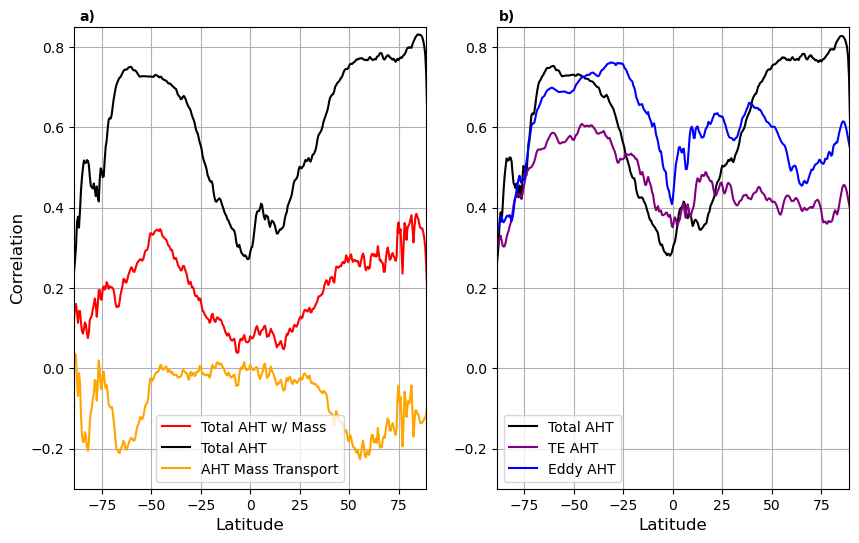

In [72]:
panel_order = [['A', 'B']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

(corrs_total_mass).plot(ax=axs['A'], color='red', label='Total AHT w/ Mass')
(corrs_total).plot(ax=axs['A'], color='k', label='Total AHT')
(corrs_mass).plot(ax=axs['A'], color='orange', label='AHT Mass Transport')

#axs['A'].plot(np.linspace(-90, 90, 361), corrs_total, label='Total AHT', color='k')
#axs['A'].plot(np.linspace(-90, 90, 361), corrs_mass, color='b',
              #label='AHT Mass Transport')
#axs['B'].plot(np.linspace(-90, 90, 361), corrs_total_mass, label='Total AHT w/ mass')

corrs_total_mse.plot.line(ax=axs['B'], label='Total AHT', color='k')
corrs_te_mse.plot.line(ax=axs['B'],label='TE AHT', color='purple')
corrs_eddy_mse.plot.line(ax=axs['B'],label='Eddy AHT', color='blue')

axs['A'].grid()
axs['B'].grid()

axs['A'].legend(loc=0)
axs['B'].legend(loc=0)

axs['A'].set_xlim([-89, 89])
axs['B'].set_xlim([-89, 89])

axs['A'].set_ylabel('Correlation', fontsize=12)
#axs['B'].set_ylabel('Correlation', fontsize=12)
axs['A'].set_xlabel('Latitude', fontsize=12)
axs['B'].set_xlabel('Latitude', fontsize=12)

axs['A'].set_ylim([-0.3, 0.85])
axs['B'].set_ylim([-0.3, 0.85])
#axs['A'].set_title('Standard Deviations')
#axs['B'].set_title('Correlations with \n column MSE tendency')
fig.text(0.13, 0.89, 'a)', fontweight='semibold')
fig.text(0.55, 0.89, 'b)', fontweight='semibold')

#plt.savefig('figures/aht_mse_tend_corrs', bbox_inches='tight')

plt.show()

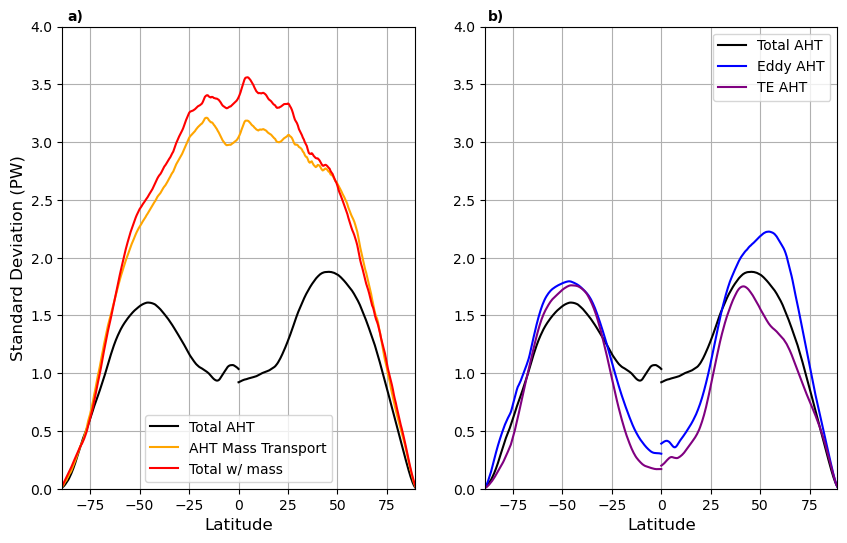

In [70]:
panel_order = [['A', 'B']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

aht_ds_djf = aht_ds.sel(time=aht_ds.time.dt.month.isin([12, 1, 2]))
aht_ds_jja = aht_ds.sel(time=aht_ds.time.dt.month.isin([6, 7, 8]))
te_ds_djf = te_ds.sel(time=te_ds.time.dt.month.isin([12, 1, 2]))
te_ds_jja = te_ds.sel(time=te_ds.time.dt.month.isin([6, 7, 8]))
mass_aht_djf = mass_aht.sel(time=mass_aht.time.dt.month.isin([12, 1, 2]))
mass_aht_jja = mass_aht.sel(time=mass_aht.time.dt.month.isin([6, 7, 8]))

axs['A'].plot(np.linspace(90, 0, 180), np.std(aht_ds_djf.total_aht, axis=0)[:180] / 1e15,
         color='k', label='Total AHT')
axs['A'].plot(np.linspace(0, -90, 181), np.std(aht_ds_jja.total_aht, axis=0)[180:] / 1e15,
         color='k')

#axs['A'].plot(np.linspace(90, 0, 180), np.std(mass_aht_djf, axis=0)[:180] / 1e15,
         #color='orange', label='AHT Mass Transport')
#axs['A'].plot(np.linspace(0, -90, 181), np.std(mass_aht_jja, axis=0)[180:] / 1e15,
         #color='orange')

axs['A'].plot(np.linspace(90, -90, 361), np.std(mass_aht_djf, axis=0) / 1e15,
         color='orange', label='AHT Mass Transport')

axs['A'].plot(np.linspace(90, -90, 361), np.std(mass_aht_djf + aht_ds_djf.total_aht, axis=0) / 1e15,
         color='r', label='Total w/ mass')

axs['B'].plot(np.linspace(90, 0, 180), np.std(aht_ds_djf.total_aht, axis=0)[:180] / 1e15,
         color='k', label='Total AHT')
axs['B'].plot(np.linspace(0, -90, 181), np.std(aht_ds_jja.total_aht, axis=0)[180:] / 1e15,
         color='k')

axs['B'].plot(np.linspace(90, 0, 180), np.std(aht_ds_djf.eddy_aht, axis=0)[:180] / 1e15,
         color='blue', label='Eddy AHT')
axs['B'].plot(np.linspace(0, -90, 181), np.std(aht_ds_jja.eddy_aht, axis=0)[180:] / 1e15,
         color='blue')

axs['B'].plot(np.linspace(90, 0, 180), (te_ds_djf.te_aht.std('time')[:180] / 1e15),
         color='purple', label='TE AHT')

axs['B'].plot(np.linspace(0, -90, 181), (te_ds_jja.te_aht.std('time')[180:] / 1e15),
         color='purple',)

axs['A'].grid()
axs['B'].grid()

axs['A'].legend(loc=0)
axs['B'].legend(loc=0)

axs['A'].set_xlim([-89, 89])
axs['B'].set_xlim([-89, 89])

axs['A'].set_ylabel('Standard Deviation (PW)', fontsize=12)
#axs['B'].set_ylabel('Correlation', fontsize=12)
axs['A'].set_xlabel('Latitude', fontsize=12)
axs['B'].set_xlabel('Latitude', fontsize=12)

axs['A'].set_ylim([0, 4])
axs['B'].set_ylim([0, 4])
#axs['A'].set_title('Standard Deviations')
#axs['B'].set_title('Correlations with \n column MSE tendency')
fig.text(0.13, 0.89, 'a)', fontweight='semibold')
fig.text(0.55, 0.89, 'b)', fontweight='semibold')

#plt.savefig('figures/aht_comparisons_std_dev', bbox_inches='tight')

plt.show()

In [32]:
aaron_corrs = scipy.io.loadmat('DJF_JJA_AHTMF_CORR_STD.mat')


aaron_corrs.keys()

dict_keys(['__header__', '__version__', '__globals__', 'CORR_AHTDIVMF_TEN', 'CORR_AHTDIVTOT_TEN', 'CORR_AHTDIV_TEN', 'STD_AHT', 'STD_AHTMF', 'STD_AHT_with_MF', 'lat'])

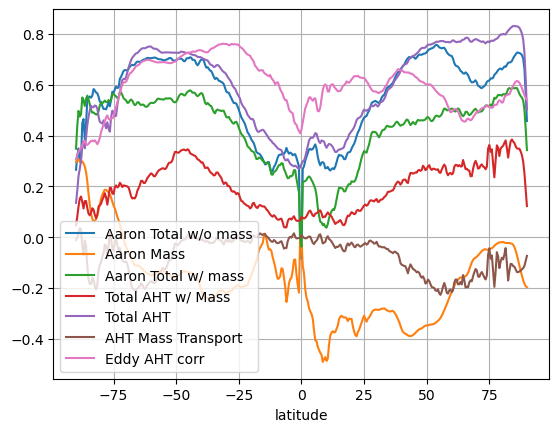

In [39]:
aaron_lat = aaron_corrs['lat'].flatten()

plt.plot(aaron_lat, aaron_corrs['CORR_AHTDIV_TEN'].flatten(), label='Aaron Total w/o mass')
plt.plot(aaron_lat, aaron_corrs['CORR_AHTDIVMF_TEN'].flatten(), label='Aaron Mass')
plt.plot(aaron_lat, aaron_corrs['CORR_AHTDIVTOT_TEN'].flatten(), label='Aaron Total w/ mass')

(corrs_total_mass).plot(label='Total AHT w/ Mass')
(corrs_total).plot(label='Total AHT')
(corrs_mass).plot(label='AHT Mass Transport')
#corrs_eddy_mse.plot.line(label='Eddy AHT corr')

plt.legend(loc=0)
plt.grid()
plt.show()

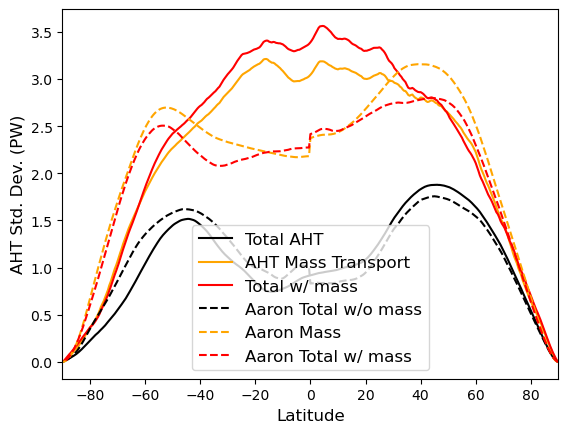

In [47]:
plt.plot(np.linspace(90, -90, 361), np.std(aht_ds_subset.total_aht, axis=0) / 1e15,
         color='k', label='Total AHT')

plt.plot(np.linspace(90, -90, 361), np.std(mass_aht, axis=0) / 1e15,
         color='orange', label='AHT Mass Transport')

plt.plot(np.linspace(90, -90, 361), np.std(mass_aht + aht_ds_subset.total_aht, axis=0) / 1e15,
         color='r', label='Total w/ mass')

plt.plot(aaron_lat, aaron_corrs['STD_AHT'].flatten() / 1e15, '--', color='k', label='Aaron Total w/o mass')
plt.plot(aaron_lat, aaron_corrs['STD_AHTMF'].flatten() / 1e15, '--', color='orange', label='Aaron Mass')
plt.plot(aaron_lat, aaron_corrs['STD_AHT_with_MF'].flatten() / 1e15, '--', color='r', label='Aaron Total w/ mass')

plt.legend(loc=0, fontsize=12)

plt.xlim([-90, 90])

plt.xlabel('Latitude', fontsize=12)
plt.ylabel('AHT Std. Dev. (PW)', fontsize=12)

#plt.savefig('../dissertation_figures/aht_mass_std_dev', bbox_inches='tight')

plt.show()

In [ ]:
####OLD####